In [54]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
  !wget -O basic_material.py https://www.dropbox.com/s/3aoexl8vxyitmds/basic_material.py?dl=0
%run basic_material

try:
    import google.colab
    IN_COLAB = True
    # don't need serial here
except:
    IN_COLAB = False
    try: 
        import serial
    except:
        !pip3 install pyserial
        import serial

import time, csv, os, requests
 
from os import path
if os.path.isdir("./data/"):
    pass
else:
    !mkdir ./data
    
if os.path.isdir("./figs/"):
    pass
else:
    !mkdir ./figs

Running Python: 3.8.16


(Thrun, Burgard and Fox) Consider a robot moving in an environment with 2D static landmarks. The discretized robot kinematics are

$$
\mathbf{x}_{k+1} =
f(\mathbf{x}_k,\mathbf{u}) = 
\begin{pmatrix}
x_k \\
y_k \\
\theta_k
\end{pmatrix} + 
\begin{pmatrix}
-\frac{v}{\omega}\sin{\theta_k} + \frac{v}{\omega}\sin{(\theta_k + \omega \Delta t)} \\
\frac{v}{\omega}\cos{\theta_k} - \frac{v}{\omega}\cos{(\theta_k + \omega \Delta t)} \\
\omega \Delta t
\end{pmatrix}
$$

with the control input $\mathbf{u}=\begin{pmatrix}\bar{v}&\bar{\omega}\end{pmatrix}^\top$, where $\bar{v}$ is the desired linear velocity (in the direction of the robot's heading, $\theta$) and $\bar{\omega}$ the desired angular velocity. To account for nonlinear effects such as wheel slip and friction, we add Gaussian noise to the desired velocity command such that

$$
\mathbf{u} = \begin{pmatrix} v \\ \omega \end{pmatrix} =
\begin{pmatrix} \bar{v} \\ \bar{\omega} \end{pmatrix} +
\begin{pmatrix} \eta_v \\ \eta_\omega \end{pmatrix}
$$

where $\eta_v\sim\mathcal{N}(0, \alpha_1 v^2 + \alpha_2 \omega^2)$ and $\eta_\omega\sim\mathcal{N}(0, \alpha_3 v^2 + \alpha_4 \omega^2)$.

The robot is equipped with a camera that allows it to measure range and bearing to observed landmarks. At each timestep, a single randomly selected landmark is observed. The robot knows which landmark it is observing (i.e., data association is assumed known). Given a landmark position $L\in\mathbb{R}^2$, the measurement model is

$$
h(\mathbf{x}_k; L) = 
\begin{pmatrix}
\| \mathbf{x}_k - L\| \\
\arctan{\left(\dfrac{L_y - \mathbf{x}_{k,y}}{L_x - \mathbf{x}_{k,x}}\right)} - \mathbf{x}_{k,\theta}
\end{pmatrix}.
$$

Using these models, implement a UKF to localize the position and heading of the robot given measurements to known landmark positions. Much of the code has been written for you---your task is to implement the `filter` method of the `UKF` class below.

The UKF outlined in lecture 14 slides is for *additive* noise (i.e., $\dot{x}=f(x,u)+w$) but the model given above has non-additive noise entering the dynamics via the input. In this case, the unscented transform is applied to the *augmented* state, $\mu=\begin{pmatrix}\mathbf{x}_k^\top & \mathbf{0}^\top & \mathbf{0}^\top \end{pmatrix}^\top$ with augmented covariance $\Sigma=\mathrm{blkdiag}(Q, W, V)$. In this case, sigma points only need to be generated once time for propagation, instead of for both the propagation and measurement update steps. Consider implementing an augmented UKF and comparing performance for different noises. Which one performs better for a wider range of tuning? See Thrun et al., *Probabilistic Robotics*, Section 7.7 for more information and pseudocode.

In [55]:
class Robot:
    """
    Velocity-controlled two-wheeled robot (e.g., think Roomba)
    
    The robot has state (x, y, θ) with motion model as
    described in Probabilistic Robotics by Thrun ch. 5d
    """
    def __init__(self, dt, x0, L):
        """
        Constructor
        
        Parameters
        ----------
        dt : float
            time step
        x0 : (3,) np.array
            (unknown) true initial state - (x, y, θ)
        L : (2,m) np.array
            known 2D static landmark positions
        """
        self.dt = dt
        self.L = L
        
        self.x = copy.deepcopy(x0) # unknown true state
        
        # state and control history
        self.xh = [copy.deepcopy(x0)]
        self.uh = []
        
        # (unknown) measurement noise for each landmark
        self.R = np.diag([0.025, 0.05])
        
    @staticmethod
    def W(u, alphas=[0.1, 0.01, 0.01, 0.1]):
        """
        Generate processn noise covariance matrix
        
        The process noise is due to the fact that velocity commands
        are not instantaneously achieved because of effects such
        as wheel slippage, friction, etc.
        
        Parameters
        ----------
        u : (2,) np.array
            velocity command: (v, ω)
        alphas : 4-list
            noise characteristics
            
        Returns
        -------
        W : (2,) np.array
            process noise covariance matrix
        """
        
        # create variance according to noise model
        var1 = alphas[0] * u[0]**2 + alphas[1] * u[1]**2
        var2 = alphas[2] * u[0]**2 + alphas[3] * u[1]**2
        return np.diag([var1, var2])
    
    @staticmethod
    def f(x, u, dt):
        """
        Motion model of robot
        
        Parameters
        ----------
        x : (3,) np.array
            current state
        u : (2,) np.array
            velocity command
            
        Returns
        -------
        xp : (3,) np.array
            propagated state
        """
        # for brevity
        v, ω = u
        sθ = np.sin(x[2])
        cθ = np.cos(x[2])
        sθω = np.sin(x[2] + ω * dt)
        cθω = np.cos(x[2] + ω * dt)

        # propagate state forward
        xp = np.zeros_like(x)
        xp[0] = x[0] - v/ω * sθ + v/ω * sθω
        xp[1] = x[1] + v/ω * cθ - v/ω * cθω
        xp[2] = x[2] + ω * dt
        
        return xp
    
    @staticmethod
    def h(x, L):
        """
        Measurement model for range and bearing sensor
        
        Parameters
        ----------
        x : (3,) np.array
            current state
        L : (p,2) np.array
            true positions of p observed 2D landmarks
            
        Returns
        -------
        z : (2*p,) np.array
            range and bearing measurements to each observed landmark
        """
        p = L.shape[0]
        if len(x.shape) == 1:
            z = np.zeros((2*p,))
        elif len(x.shape) == 2: # handle particle set inputs
            z = np.zeros((2*p,x.shape[1]))
        
        for i, l in enumerate(L):
            z[2*i] = np.linalg.norm(x[:2].reshape((2,-1)) - l.reshape((2,1)), axis=0)
            z[2*i+1] = np.arctan2(l[1] - x[1], l[0] - x[0]) - x[2]

        return z
    
    def move(self, u):
        """
        Physics simulation of robot
        
        Parameters
        ----------
        u : (2,) np.array
            velocity command: (v, ω)
        """

        # add noise to desired commands
        unoisy = np.random.multivariate_normal(u, self.W(u))
        
        # propagate state forward
        self.x = self.f(self.x, unoisy, self.dt)
        
        # keep history
        self.uh.append(copy.deepcopy(unoisy))
        self.xh.append(copy.deepcopy(self.x))
    
    def sense(self):
        """
        Use simulated sensor to gather range and bearing measurements
        
        Only a single landmark is measured. It is selected randomly.
        Data association is assumed solved, i.e., landmarks have unique
        IDs and it is known which landmark a measurement is associated with.
        
        Returns
        -------
        z : (2*len(l),) np.array
            noisy (range, bearing) measurements to len(l) landmarks
        l : int
            the index/label of the measured landmark
        """
        
        # randomly select p landmarks
        p = 1
        l = np.random.choice(len(self.L), p, replace=False)
        
        # simulate measurements
        z = self.h(self.x, self.L[l])
        
        # add noise
        z += np.random.multivariate_normal(np.zeros(2*p), la.block_diag(*[self.R]*p))
            
        return z, l

In [56]:
def π(t):
    """
    Control policy to generate velocity commands
    
    Parameters
    ----------
    t : float
        current time
        
    Return
    ------
    u : (2,) np.array
        velocity command (v, ω)
    """
    v = 0.0 + 0.5 #* np.cos(2 * np.pi * 0.2 * t)
    ω = -0.04 # -0.2 #+ 2.0 * np.cos(2 * np.pi * 0.6 * t)
    return np.array([v,ω])

### UKF Implementation

In [57]:
class UKF:
    """
    Unscented Kalman Filter
    """
    def __init__(self, robot, x0, Q0, augmented=False, α=1, β=2, κ=0):
        """
        Constructor
        
        Parameters
        ----------
        robot : Robot
            Robot object describing the process we are filtering for
        x0 : (3,) np.array
            initial state for filter (ideally as close to actual robot as possible)
        Q0 : (3,3) np.array
            initial estimation error covariance (commensurate with belief in x0)
        augmented : bool
            should use augmented or additive UKF formulation
        α : float
        β : int
        κ : int
        """
        
        # filter state and estimation error covariance
        self.xhat = copy.deepcopy(x0)
        self.Q = copy.deepcopy(Q0)
        
        # filter state and cov history
        self.xhath = [copy.deepcopy(x0)]
        self.Qh = [copy.deepcopy(Q0)]
        
        # construct unscented transform weights
        
        # unscented transform parameters
        self.α = α
        self.β = β
        self.κ = κ
        
        # hold onto robot model for dynamics, landmark positions, etc
        self.robot = robot
        
        # motion and measurement model to use
        # n.b., this assumes we have perfect model knowledge
        self.f = robot.f
        self.h = robot.h
        
        same_noise = True
        self.augmented = augmented
        if same_noise:
            if self.augmented:
                self.W = robot.W # process noise is a fcn of control
                self.R = robot.R
            else:
                self.W = np.diag([1., 1., 1.])*0.1
                self.R = robot.R*10
        else:
            if self.augmented:
                self.W = lambda u: robot.W(u, alphas=[0.1, 0.05, 0.05, 0.1])
                self.R = robot.R
            else:
                self.W = np.diag([1., 1., 1.])*0.1
                self.R = np.diag([0.01, 0.01])*100
    
    def filter_additive(self, u, z, l):
        """
        Applies the UKF at the current time step
        
        Parameters
        ----------
        u : (2,) np.array
            desired velocity command: (v, ω)
        z : (2*len(l),) np.array
            noisy (range, bearing) measurements to len(l) landmarks
        l : int
            the index/label of the measured landmark
        """
        
        # dimensions and stuff
        n, = self.xhat.shape  # num states
        k, = u.shape          # num inputs
        mm, = z.shape         # num measurements
               
        # unscented transform weights
        Wm = np.zeros(2 * n + 1)
        Wc = np.zeros(2 * n + 1)
        
        λ = self.α**2 * (n + self.κ) - n
        Wm[:] = 0.5/(n + λ)
        Wc[:] = 0.5/(n + λ)
        Wm[0] = λ/(λ + n)
        Wc[0] = λ/(λ + n) + (1 - self.α**2 + self.β)
        #
        # Propagation
        #
        # Generate sigma points
        sqrtQ = np.linalg.cholesky((λ + n) * self.Q).T
        X = np.column_stack([self.xhat, (self.xhat + sqrtQ.T).T, (self.xhat - sqrtQ.T).T])

        # Pass sigma points through motion model
        Xp = self.f(X, u, self.robot.dt)
        
        # Recover Gaussian statistics - mean and covariance
        self.xhat = np.sum(Wm * Xp, axis=1)
        self.Q = ((Xp.T - self.xhat).T * Wc).dot(Xp.T - self.xhat) + self.W
        #
        # Update
        #
        # Generate new sigma points
        sqrtQ = np.linalg.cholesky((λ + n) * self.Q).T
        Xp = np.column_stack([self.xhat, (self.xhat + sqrtQ.T).T, (self.xhat - sqrtQ.T).T])

        # Pass sigma points through measurement model
        Z = self.h(Xp, self.robot.L[l])

        # Recover Gaussian statistics - mean and covariance
        zhat = np.sum(Wm * Z, axis=1)
        S = ((Z.T - zhat).T * Wc).dot(Z.T - zhat) + self.R

        # Recover cross covariance
        Σ_xz = ((Xp.T - self.xhat).T * Wc).dot(Z.T - zhat)

        # Perform measurement update
        K = Σ_xz @ np.linalg.inv(S)
        self.xhat += K @ (z - zhat)
        self.Q += - K @ S @ K.T
        
    def filter_augmented(self, u, z, l):
        """
        Applies the UKF at the current time step
        
        This version uses the augmented state trick and avoids
        regenerating sigma points for the update step.
        
        Parameters
        ----------
        u : (2,) np.array
            desired velocity command: (v, ω)
        z : (2*len(l),) np.array
            noisy (range, bearing) measurements to len(l) landmarks
        l : int
            the index/label of the measured landmark
        """
        
        # dimensions and stuff
        n, = self.xhat.shape  # num states
        k, = u.shape          # num inputs
        mm, = z.shape         # num measurements
        
        # augmented state size
        na = n + k + mm
        
        # unscented transform weights
        Wm = np.zeros(2 * na + 1)
        Wc = np.zeros(2 * na + 1)
        
        λ = self.α**2 * (na + self.κ) - na
        Wm[:] = 0.5/(na + λ)
        Wc[:] = 0.5/(na + λ)
        Wm[0] = λ/(λ + na)
        Wc[0] = λ/(λ + na) + (1 - self.α**2 + self.β)
        
        #
        # Propagation
        #

        # Generate augmented mean and covariance
        μ_a = np.concatenate((self.xhat, np.zeros(k), np.zeros(mm)))
        Σ_a = la.block_diag(self.Q, self.W(u), self.R)

        # Generate sigma points
        sqrtΣ = np.linalg.cholesky((λ + na) * Σ_a).T
        X_a = np.column_stack([μ_a, (μ_a + sqrtΣ.T).T, (μ_a - sqrtΣ.T).T])

        # Pass sigma points through motion model
        X_x, X_u = X_a[0:n,:], X_a[n:n+k,:]
        X_xp = self.f(X_x, (u + X_u.T).T, self.robot.dt)
        
        # Recover Gaussian statistics - mean and covariance
        self.xhat = np.sum(Wm * X_xp, axis=1)
        self.Q = ((X_xp.T - self.xhat).T * Wc).dot(X_xp.T - self.xhat)
        
        #
        # Update
        #

        # Pass sigma points through measurement model
        X_z = X_a[-mm:,:]
        Z = self.h(X_xp, self.robot.L[l]) + X_z

        # Recover Gaussian statistics - mean and covariance
        zhat = np.sum(Wm * Z, axis=1)
        S = ((Z.T - zhat).T * Wc).dot(Z.T - zhat)

        # Recover cross covariance
        Σ_xz = ((X_xp.T - self.xhat).T * Wc).dot(Z.T - zhat)

        # Perform measurement update
        K = Σ_xz @ np.linalg.inv(S)
        self.xhat += K @ (z - zhat)
        self.Q += - K @ S @ K.T
        
    
    def filter(self, u, z, l):
        """
        Applies the UKF at the current time step
        
        Parameters
        ----------
        u : (2,) np.array
            desired velocity command: (v, ω)
        z : (2*len(l),) np.array
            noisy (range, bearing) measurements to len(l) landmarks
        l : int
            the index/label of the measured landmark
        """
        
        if self.augmented:
            self.filter_augmented(u, z, l)
        else:
            self.filter_additive(u, z, l)
        
        # logging
        self.xhath.append(copy.deepcopy(self.xhat))
        self.Qh.append(copy.deepcopy(self.Q))

### Simulation

The following code sets up the simulation loop with the appropriate landmark positions.

In [18]:
dt = 0.5
tvec = np.arange(0,100+dt,dt)

# initial conditions
Q0 = np.diag([1., 1., 1.])*1e-1
x0 = np.array([-5, -3, np.pi/2]) + sqrtm(Q0)@randn(3)

# known landmark positions
L = np.array([[6., 4.],[-7., 8.],[6., -4.],[0, 0],[0, -10],[15, 15],[15, -15]])

robot = Robot(dt, x0, L)
ukf = UKF(robot, x0, Q0, augmented=False)

In [19]:
for t in tvec:
    
    # use policy to generate desired command
    u = π(t)
    
    # ------------ Robot simulation (i.e., the plant) ------------
    
    # move the robot
    robot.move(u)
    
    # sense the environment
    z, l = robot.sense()
    
    # ------------------------------------------------------------
    
    # perform UKF localization (i.e., estimate robot state (x, y, θ))
    ukf.filter(u, z, l)

### Plotting Code

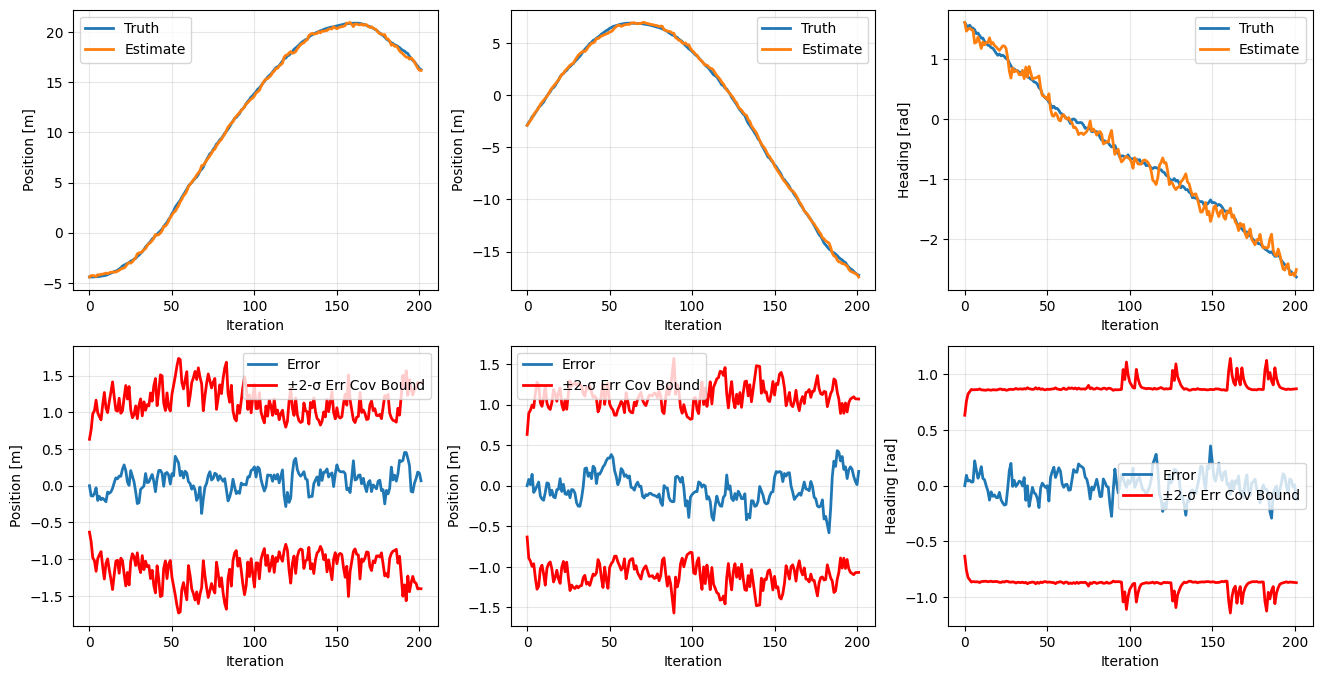

In [20]:
xgt = np.array(robot.xh)
xhat = np.array(ukf.xhath)
xerr = xgt - xhat
Qdiag = np.array([np.diag(Q) for Q in ukf.Qh]) # variances of est err
σbnd = 2

fig, ax = plt.subplots(2,3,figsize=(16,8))

ylabels = ['Position [m]', 'Position [m]', 'Heading [rad]']

for i in range(3):
    ax[0][i].plot(xgt[:,i],label='Truth')
    ax[0][i].plot(xhat[:,i],label='Estimate')
    ax[0][i].set_xlabel('Iteration')
    ax[0][i].set_ylabel(ylabels[i])
    ax[0][i].legend()
    ax[0][i].grid(alpha=0.3)
    
for i in range(3):
    ax[1][i].plot(xerr[:,i],label='Error')
    ax[1][i].plot( σbnd*np.sqrt(Qdiag[:,i]), label=f'±{σbnd}-σ Err Cov Bound', color='r')
    ax[1][i].plot(-σbnd*np.sqrt(Qdiag[:,i]), color='r')
    ax[1][i].set_xlabel('Iteration')
    ax[1][i].set_ylabel(ylabels[i])
    ax[1][i].legend()
    ax[1][i].grid(alpha=0.3)

### Animation Code for Visualization

In [21]:
class LocalizationAnimation:
    """
    Utility to visualize robot localization problem
    """
    def __init__(self, robot, ukf):
        """
        Constructor
        
        Parameters
        ----------
        robot : Robot
            Robot object containing state history
        ukf : UKF
            UKF object containing state history
        """
        self.robot = robot
        self.ukf = ukf
    
    def animate(self):
        """
        Generate an animation as an HTML5 video
        """
        X = np.array(self.robot.xh)
        Xhat = np.array(self.ukf.xhath)
        
        dt = self.robot.dt
        T = X.shape[0]
        
        xm = -20
        xM = 20
        ym = -20
        yM = 20
        
        env = plt.figure(figsize=(5, 5), dpi=150)
        ax = env.add_subplot(1, 1, 1)
        ax.set_xlim((xm, xM))
        ax.set_ylim((ym, yM))
        ax.set_title("Robot Environment",fontsize=20)
        ax.set_xlabel("X position [m]", fontsize=16)
        ax.set_ylabel("Y position [m]", fontsize=16)
        
        gt_robot = plt.Circle((X[0, 0], X[0, 1]), 1, fill=False)
        ax.add_artist(gt_robot)
        gt_dir = np.array([[0, np.cos(X[0, 2])], [0, np.sin(X[0, 2])]])
        gt_line, = ax.plot(X[0,0] + gt_dir[0, :], X[0,1] + gt_dir[1, :], 'k', label='Ground Truth')
        gt_traj, = ax.plot(X[0,0], X[0,1], 'k:')
        
        est_robot = plt.Circle((X[0,0], X[0,1]), 1, fill=False, color='r')
        ax.add_artist(est_robot)
        est_dir = np.array([[0, np.cos(X[0, 2])], [0, np.sin(X[0, 2])]])
        est_line, = ax.plot(Xhat[0,0] + est_dir[0, :], Xhat[0,1] + est_dir[1, :], 'r', label='Estimate')
        est_traj, = ax.plot(Xhat[0,0], Xhat[0,1], 'r')
        
        ax.plot(self.robot.L[:, 0], self.robot.L[:, 1], 'gD', label='Landmarks')
        
        ax.legend()
        def animate(i):
            gt_dir = np.array([[0, np.cos(X[i, 2])], [0, np.sin(X[i, 2])]])
            gt_line.set_data(X[i,0] + gt_dir[0, :], X[i,1] + gt_dir[1, :])
            gt_robot.center = X[i,0], X[i,1]
            gt_traj.set_data(X[:i,0], X[:i,1])
            
            est_dir = np.array([[0, np.cos(Xhat[i, 2])], [0, np.sin(Xhat[i, 2])]])
            est_line.set_data(Xhat[i,0] + est_dir[0, :], Xhat[i,1] + est_dir[1, :])
            est_robot.center = Xhat[i,0], Xhat[i,1]
            est_traj.set_data(Xhat[:i,0], Xhat[:i,1])
            return (gt_line,gt_traj,est_line,est_traj,)
        
        anim = animation.FuncAnimation(env, animate, frames=T, interval=dt*500, blit=True)
        return anim.to_html5_video()

In [15]:
# generate animation - will take ~20 seconds to make video
ani = LocalizationAnimation(robot, ukf)
HTML(ani.animate())